# LISFLOOD Use Case - 1) Preprocessing
---

This use case intends to introduce the basic mechanics of the hydrological model [LISFLOOD](https://github.com/ec-jrc/lisflood-code/).
<br>
In this exercise, the objective is to get used to some often required basic preprocessing steps in the course of modeling with LISFLOOD.
<br> <br>
We will first start with cutting out a map with LISFLOOD using [LISFLOOD-Utilities](https://github.com/ec-jrc/lisflood-utilities). 

## 1a) Cutmaps

The **`cutmaps` tool** from *LISFLOOD-Utilities* provides an easy way to prepare  
**basin-specific input maps** from global datasets (e.g. *GloFAS*) or from larger spatial extents.

The tool can be used either via the **command line** or **directly in Python**.  
The example shown here cuts **one input map** to our river basin, but the same command can also be used to cut the content of an **entire folder** to a specific extent.

Users can cut maps based on:
1. a *bounding box of coordinates*
2. a *bounding box of matrix indices*
3. an *existing boolean area mask*
4. a *list of stations* and a **LDD** (*local drain direction*, NetCDF or PCRaster)

For many hydrological studies, the **latter option**, cutting maps based on *specific outlet locations in the river network*,is the **standard and most important use case**.

We provide a shell script called **`cutmaps.sh`**, which clips the NetCDF file  
`upArea_unclipped.nc` to the location of our outlet gauge stored in `outlet.txt`.  
Both files are located in the **`station/`** folder, while the upstream area file is found under **`maps/`**.

---

However, we will first have a look atthe original unclipped upstream area file and outlet location using Python.

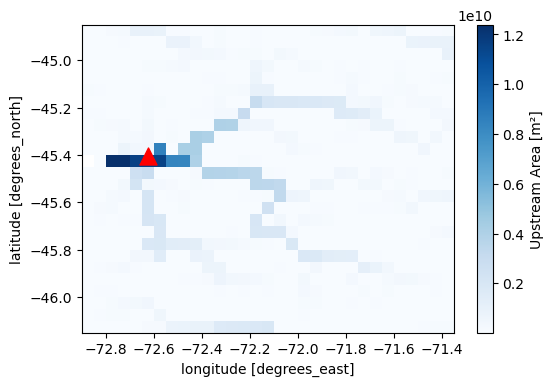

In [ ]:
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
#from lisflood_read_plot import plot_map_timeseries, plot_mapstacks # to be checked did not work for me

# read input
path_model = Path('..')
uparea_file = "upArea_unclipped.nc"
outlet_file = "outlet.txt"
uparea_orig = xr.open_dataset(path_model / "maps" / uparea_file)
outlet = pd.read_csv(path_model / "station" / outlet_file,delimiter="\t", names=["lon", "lat", "id"])
# map
fig, ax = plt.subplots(figsize=(6,4))
uparea_orig.Band1.plot.pcolormesh(ax=ax,cbar_kwargs={'label': 'Upstream Area [m²]'},cmap='Blues')
ax.scatter(
    outlet['lon'],
    outlet['lat'],
    color='red',      # marker color
    s=150,            # marker size
    marker='^',       # circle
);

As we can see, the drainage network and especially the three main contributing rivers within the basin get visible. 
We also see that the original map reflects a rectangular bounding box rather than a basin-clipped version, which is generally fine, 
however, for this exercise we will cut the map to the basin that belongs to our outlet point. <br>
Thus, rivers which are visible but do not contribtue to the outlet will be removed now. 

---

For this we will use the **`cutmaps.sh`** script with the following settings (how it should look):

```bash
#!/bin/bash
set -euo pipefail

WORK_DIR="./../maps/"

cutmaps \
  -F "${WORK_DIR}/upArea_unclipped.nc" \
  -l "${WORK_DIR}/ldd_repaired.map" \
  -N "outlet.txt" \
  -o "${WORK_DIR}/cutmaps_test/" \
  -W

Please adapt the paths in the file of course in case it does not match your folder and file structure of the test case!

To run the script open your console navigate to the **`station/`** folder and run **`cutmaps.sh`**. <br>
The station file is self-explaining and just has an ID and latitude, longitude coordinates. 

The flags used in our example have the following meaning:

- `-F`: NetCDF file to be cut
- `-l`: Local drainage map (LDD). Required if station coordinates are used to clip the map
- `-N`: File containing the station list (or, as in our example, a single station)
- `-o`: Output path where the resulting files will be saved
- `-W`: Overwrite existing files in the output directory

Now navigate to the folder where the cutmaps shell script is located and run **`./cutmaps.sh`**. 

We now will have a look at the result in Python. <br>
Note that after the clipping the clipped file has the **same** file name as the original one!<br>
For clarity we thus manually renamed the file to **`upArea_clipped.nc`**.


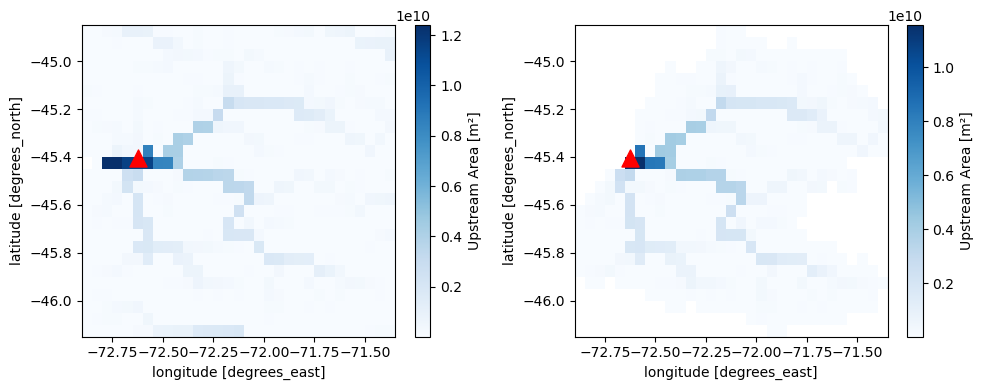

In [ ]:
# read input
path_model = Path('..')
uparea_file = "upArea_clipped.nc"
uparea_clip = xr.open_dataset(path_model / "maps" / "cutmaps_test" / uparea_file)

# map
fig, ax = plt.subplots(1,2,figsize=(10,4))
uparea_orig.Band1.plot.pcolormesh(ax=ax[0],cbar_kwargs={'label': 'Upstream Area [m²]'},cmap='Blues')
ax[0].scatter(
    outlet['lon'],
    outlet['lat'],
    color='red',      # marker color
    s=150,            # marker size
    marker='^',       # circle
);

uparea_clip.Band1.plot.pcolormesh(ax=ax[1],cbar_kwargs={'label': 'Upstream Area [m²]'},cmap='Blues')
ax[1].scatter(
    outlet['lon'],
    outlet['lat'],
    color='red',      # marker color
    s=150,            # marker size
    marker='^',       # circle
);
fig.tight_layout()

We can now see that the parts of the extent that do not contribute to the outlet are properly removed!

---


## 1b) Catchstats

Next, we will quickly introduce another utilities tool that allows users to quickly get summary statistics for the catchment with respect to a user specified nc file.<br>

The descriptive statistics that can be obtained are: 
- `mean`
- `sum`
- `std`
- `min`
- `max`

We again use a shell script called catchstats.sh to derive some aggregated catchment statistics for some input maps.<br>
In detail, we will calculate the `mean` and `max` (just for demonstration purposes) of a `soil moisture` and `forest LAI` map.
The shell script has to look like:

```bash
#!/bin/bash
set -euo pipefail

WORK_DIR="./../maps/"

catchstats \
  -i "${WORK_DIR}/catchstats_inputs" \
  -m "${WORK_DIR}/catchstats_inputs/mask" \
  -s mean max \
  -o "${WORK_DIR}/cutmaps_test/" \
  -a "${WORK_DIR}/pixarea_Global_03min.nc/"

Requirements are a mask folder (not a file!), the input folder where maps are located for which we calculate the basin statistics and in case of varying pixel areas a NetCDF file of pixel area used to weigh the statistics.

The flags used in our example are:

- `-i`: Directory containing the input NetCDF files (you cannot specifiy a single file)
- `-m`: Directory containing the mask NetCDF files (you cannot specifiy a single file)
- `-s`: List of statistics that should be computed
- `-o`: Output path where the resulting files will be saved
- `-W`: Overwrite existing files in the output directory

In our example we prepared both a mask (-m) and input (-i) folder within the maps directory. Under **`maps/catchstats_inputs/`** 2 example files are located:
1. **`thetas1_f_Global2_03min.nc`**
2. **`laif.nc`**

The files were just copies from the actual maps folder. Within the catchstats_inputs folder you will also find a **`mask/`** folder that contains the mask file used for masking when deriving the catchment statistics of the two files. <br>
Please note: the mask file needs to be named as **`<ID>.nc`**, where ID is a user specified ID! <br>
For example, you could use the cutmaps output generated before, e.g. the **`upArea_clipped.nc`** file and rename it to 7859.nc like we did.

The output file will be a NetCDF also called **`<ID>.nc`**.<br>

---
So let us have a look at the result!


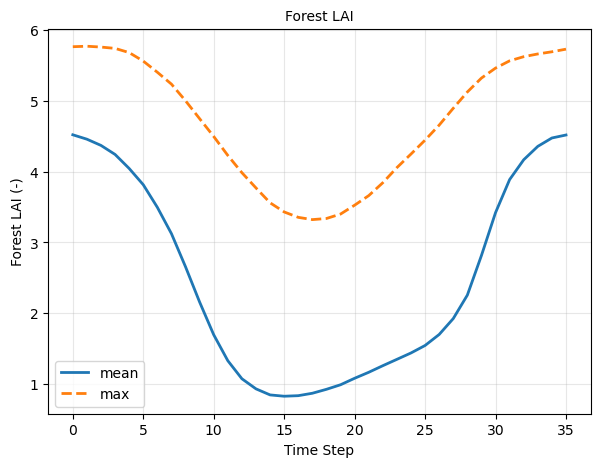

In [83]:
# read input
path_model = Path('..')
catchstat_file = "7859.nc"
catchstats = xr.open_dataset(path_model / "maps" / "cutmaps_test" / catchstat_file)
catchstats = catchstats.assign_coords(
    time=np.arange(catchstats.sizes["time"])
)
# map
VAR1  = "thetas1"
VAR2  = "laif"
STAT1 = "mean"
STAT2 = "max"

fig, ax = plt.subplots(figsize=(7,5))
catchstats[f"{VAR2}_{STAT1}"].plot(
    ax=ax,
    label=f"{STAT1}",
    linewidth=2
)
catchstats[f"{VAR2}_{STAT2}"].plot(
    ax=ax,
    label=f"{STAT2}",
    linewidth=2,
    linestyle="--"
)
ax.set_title(f"Forest LAI", fontsize=10)
ax.set_xlabel("Time Step")
ax.set_ylabel("Forest LAI (-)")
ax.grid(True, alpha=0.3)
ax.legend()